### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)


#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?



----------
## My implementation

-----
### Libraries & Functions

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib
import corner

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination


#plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15

color = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']

In [3]:
'''
function that assigns label 0 to the true positives (recognized quasars),
1 to the true negatives (recognized galaxies), 
2 to the false negatives (quazars not recognized)
& 3 to the false positives (galaxies identified as quasars)
'''

def results(y_true, y_predicted):
    
    tn = np.logical_and(y_predicted == y_true, y_true == 0)
    fn = np.logical_and(y_predicted != y_true, y_true == 1)
    fp = np.logical_and(y_predicted != y_true, y_true == 0)
    
    label = np.zeros(len(y_true))  
    label[tn] = 1                     
    label[fn] = 2
    label[fp] = 3
    
    return label



'''
assigns to data labelled 'QSO' the label 1, 0 to data labelled 'GALAXY' 
'''
def numlabels(y):
    newy = np.zeros(len(y))
    for i in range(len(y)):
        if y[i] =='QSO':
            newy[i] = 1
    return newy





''' computes the rms error'''
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)
                   / len(y))


'''
given a classifier with an hyperparameter, it computes the trianing and cv error doing kfold cross validation
and a median for the errors obtained at each K cycle
'''
def errors_cv(X, y, clf):
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        
        clf.fit(X_train, y_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
        #print(trainerr, cverr)
    
    return np.median(cverr), np.median(trainerr)

--------

### Data

In [4]:
# Read data
path = '/Users/giuliamariaborro/box/reps/astrostatistics_bicocca_2022/solutions/'
data=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')
names = data.dtype.names
data=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)
d = dict(zip(names, data.T))
lab=np.genfromtxt(path+'galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)

# Create arrays for the (u−g), (g−r), (r−i), and (i−z) colors
for diff in ['ug', 'gr', 'ri', 'iz']:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

Store color data and labels in X,y

In [5]:
# create a X,y with data of colors and the respective labels
X = np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = numlabels(d['lab'])
features = ['u-g', 'g-r', 'r-i', 'i-z']

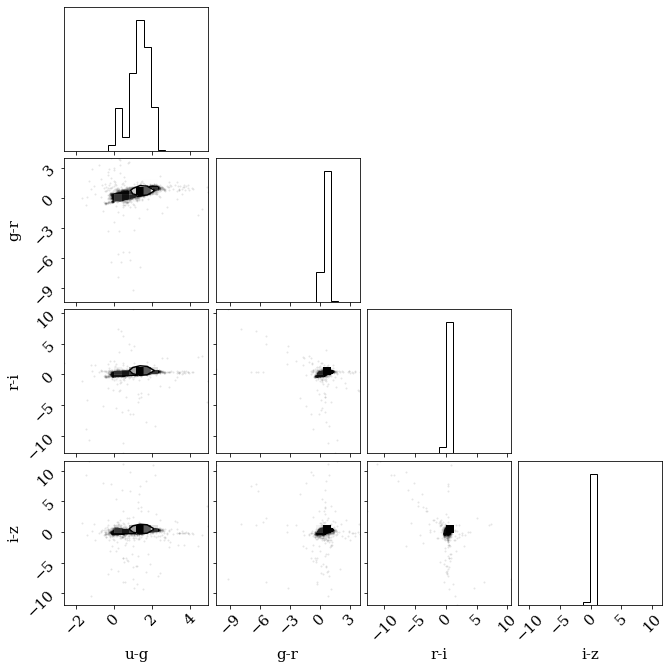

In [6]:
corner.corner(X, labels=features, levels=[0.5, 0.9]);

u-g shows a bimodality:

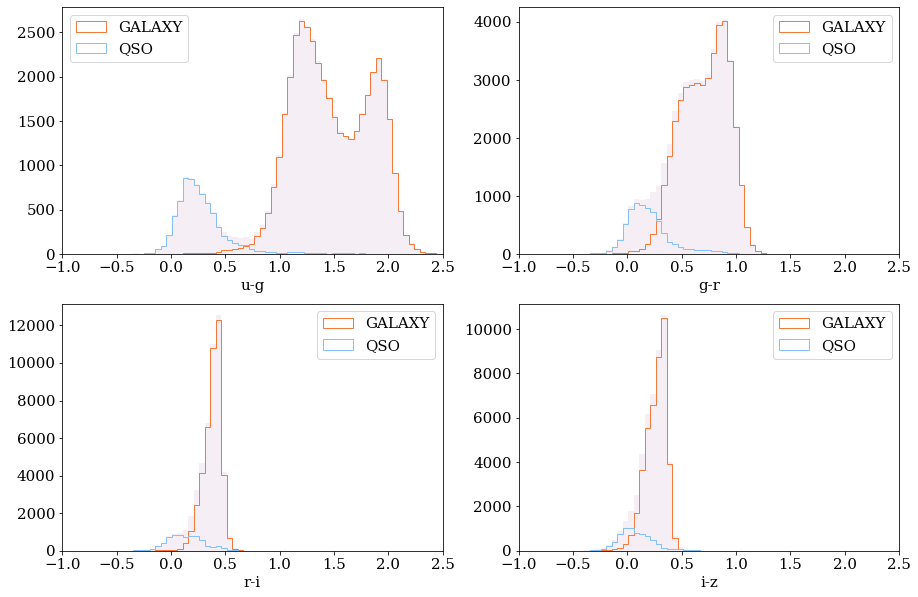

In [7]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-0.5, 3, 70)

for a,i in zip(axs, range(len(X))):
    a.hist(X[:,i], bins=bins, alpha=0.1, color=color[1])
    a.hist(X[:,i][y==0], bins=bins, histtype='step', color=color[0], lw=1,label='GALAXY')
    a.hist(X[:,i][y==1], bins=bins, histtype='step', color=color[2], lw=1,label='QSO')
    
    a.set_xlabel(features[i])
    a.set_xlim(-1,2.5)
    a.legend();

For classification we explore u-g, g-r colorplot.

### Classification

We'll use the following classifiers: Gaussian Naive Bayes, Gaussian Mixture Bayes, K-Nearest Neighbor

#### Cross validation for GMMB

In [9]:
# split in training and test set
X_train, X_test, y_train, y_test = train_test_split(
     X[:,0:2], y, test_size=0.2, random_state=8)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40000, 2) (40000,) (10000, 2) (10000,)


I divided the dataset in train and test.
Now I take the X_train, y_train set and I further split them in order to perform a 5-fold cross validation.

In [15]:
kf = KFold(n_splits=10, shuffle=True, random_state=8)

In [16]:
ncom = np.linspace(1, 20, 20, dtype=int)
cverr_GMMB =[]
trainerr_GMMB = []

for n in ncom:
    gmmb = GMMBayes(n, random_state=8)
    cverr, trainerr = errors_cv(X_train, y_train, gmmb)
    cverr_GMMB.append(cverr)
    trainerr_GMMB.append(trainerr)
    
ncom_best = ncom[cverr_GMMB == min(cverr_GMMB)][0]
print('best number of components:',ncom_best)

best number of components: 13


Text(0.5, 0, 'number of components')

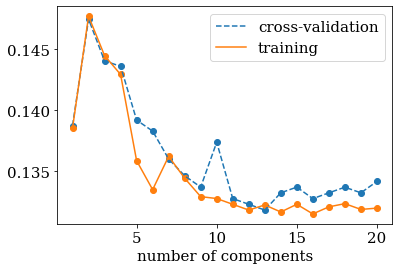

In [17]:
plt.scatter(ncom, cverr_GMMB)
plt.scatter(ncom, trainerr_GMMB)
plt.plot(ncom, cverr_GMMB, '--', label='cross-validation')
plt.plot(ncom, trainerr_GMMB, '-', label='training')
plt.legend()
plt.xlabel('number of components')

#### Cross Validation for KNN 

In [18]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors': np.linspace(1,20,20, dtype=int)}, cv=5)
grid.fit(X_train, y_train)
k_best = grid.best_params_['n_neighbors']
print('best_value:', k_best);

best_value: 11


### CLASSIFICATION

In [16]:
# GNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# GMMB
gmmb = GMMBayes(ncom_best, random_state=8)
gmmb.fit(X_train, y_train)
y_pred_gmmb = gmmb.predict(X_test)

# KNNC
knn = KNeighborsClassifier(k_best)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

#### Compare models

Label = 0: quasars correctly identified. 
Label = 1: galaxies correctly identified. 
Label = 2: quasars exchanged for galaxies. 
Label = 3: galaxies exchanged for quasars.


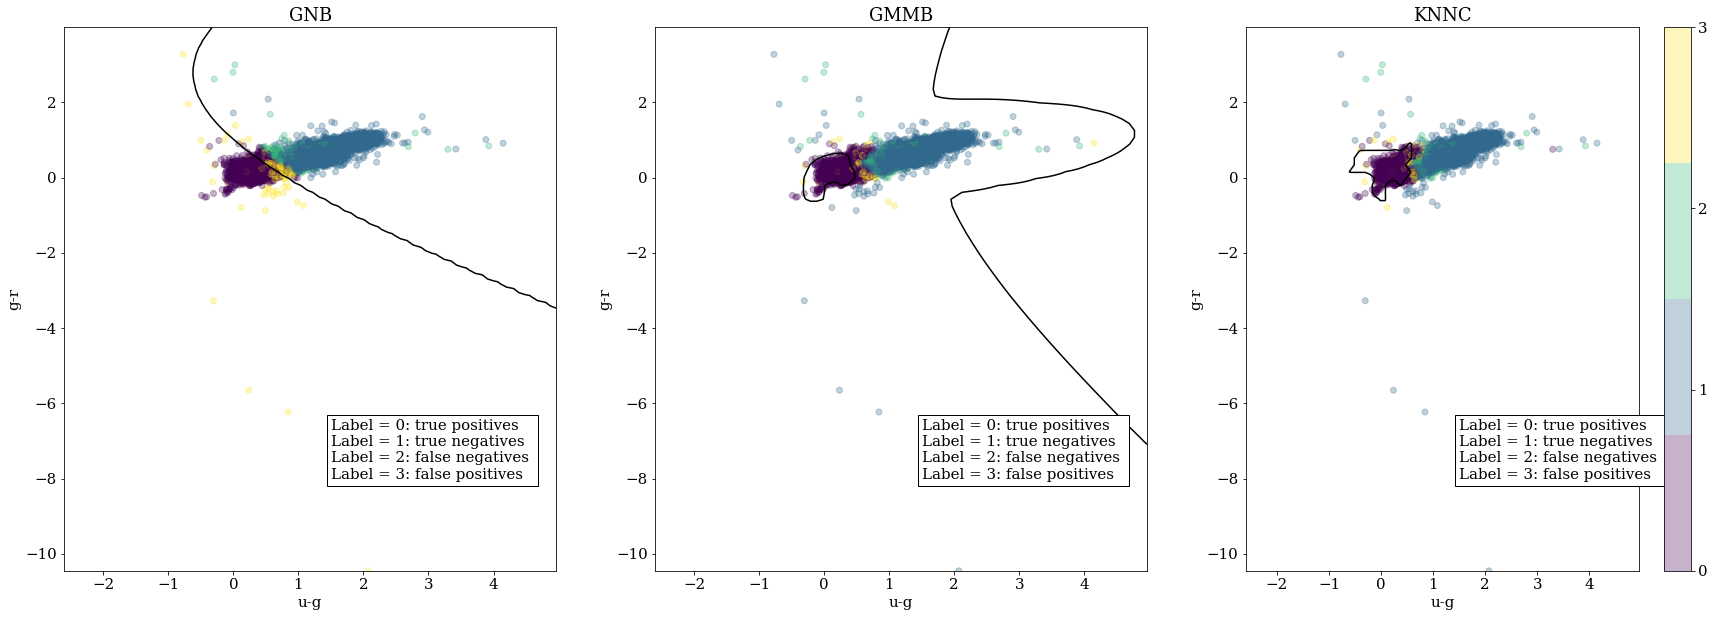

In [17]:
### PLOT THE RESULTS
fig, ax = plt.subplots(1,3, figsize = (30, 10))
axs = [ax[0], ax[1], ax[2]]
clf = ['GNB', 'GMMB', 'KNNC']


# assigns different labels for true/false positives/negatives
label = [results(y_test, y_pred_gnb), results(y_test, y_pred_gmmb), results(y_test, y_pred_knn)]
print('Label = 0: quasars correctly identified. \n'
       'Label = 1: galaxies correctly identified. \n'
        'Label = 2: quasars exchanged for galaxies. \n'
       'Label = 3: galaxies exchanged for quasars.'
     )
cmap = plt.cm.get_cmap('viridis', 4)


# decision boundary
xlim = [min(X[:,0]), max(X[:,0])]
ylim = [min(X[:,1]), max(X[:,1])]
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 80),
                     np.linspace(ylim[0], ylim[1], 80))

Z = [gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape),
    gmmb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape),
    knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)]



# plot the results
for a,i in zip(axs, range(len(X))):
    im = a.scatter(X_test[:,0], X_test[:,1], alpha=0.3, c =label[i], cmap=cmap) 
    a.contour(xx, yy, Z[i], [.9],colors='k')
    
    a.set_xlabel('u-g')
    a.set_ylabel('g-r')
    a.set_title(clf[i])
    a.text(1.5, -8, 'Label = 0: true positives \n'
       'Label = 1: true negatives \n'
        'Label = 2: false negatives \n'
       'Label = 3: false positives',
          bbox=dict(ec='k', fc='w'))
    

cbar = fig.colorbar(im)
tick_locs = np.arange(4)
cbar.set_ticks(tick_locs)

Confusion matrix:

In [18]:
print('GNB: \n', confusion_matrix(y_test, y_pred_gnb))
print('\n GMMB: \n', confusion_matrix(y_test, y_pred_gmmb))
print('\n KNNC: \n', confusion_matrix(y_test, y_pred_knn))

GNB: 
 [[12624   221]
 [  153  2002]]

 GMMB: 
 [[12743   102]
 [  151  2004]]

 KNNC: 
 [[12749    96]
 [  165  1990]]


ROC curves:

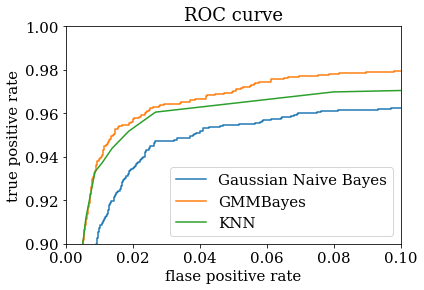

In [19]:
# Gaussian Naive Bayes
y_prob1 = gnb.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob1)


# GMMBayes
y_prob2= gmmb.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob2)


# KNN 
y_prob3= knn.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_prob3)


plt.plot(fpr1, tpr1, label='Gaussian Naive Bayes')
plt.plot(fpr2, tpr2, label='GMMBayes')
plt.plot(fpr3, tpr3, label='KNN')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.legend();

In [20]:
print('\n Number of QSO:', sum(y_test),
      '\n Number of Galaxies:', len(y_test)-sum(y_test),
      '\n Percentage of QSO:', sum(y_test)/len(y_test))


 Number of QSO: 2155.0 
 Number of Galaxies: 12845.0 
 Percentage of QSO: 0.14366666666666666


Since the size of the two populations is unbalanced, plot precision recall curve:

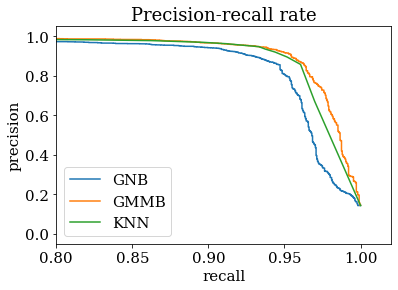

In [21]:
pr1, rec1, t1 = precision_recall_curve(y_test,  y_prob1)
pr2, rec2, t2 = precision_recall_curve(y_test,  y_prob2)
pr3, rec3, t3 = precision_recall_curve(y_test,  y_prob3)

# plot
plt.plot(rec1, pr1, label='GNB')
plt.plot(rec2, pr2,  label='GMMB')
plt.plot(rec3, pr3, label='KNN')

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-recall rate')
plt.legend()

plt.xlim(0.8, 1.02);

See accuracy:

In [22]:
print('\n accuracy for GNB:', accuracy_score(y_test, y_pred_gnb),
    '\n accuracy for GMMB:', accuracy_score(y_test, y_pred_gmmb),
     '\n accuracy for KNN:', accuracy_score(y_test, y_pred_knn))


 accuracy for GNB: 0.9750666666666666 
 accuracy for GMMB: 0.9831333333333333 
 accuracy for KNN: 0.9826


Thus, if we consider only the first two colors the classifier that performs better is the GMMB.

#### Most important feature

Now use different colors for each classifier:

In [23]:
def ROC_Features(X, y, clf):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8)
    
    for i in range(4):
        clf.fit(X_train[:,0:i+1] ,y_train)
        # print(X_train[:,0:i+1].shape)
        y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
        fpr, tpr, thresh = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=features[0:i+1])
    plt.legend()
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')

    return 0;

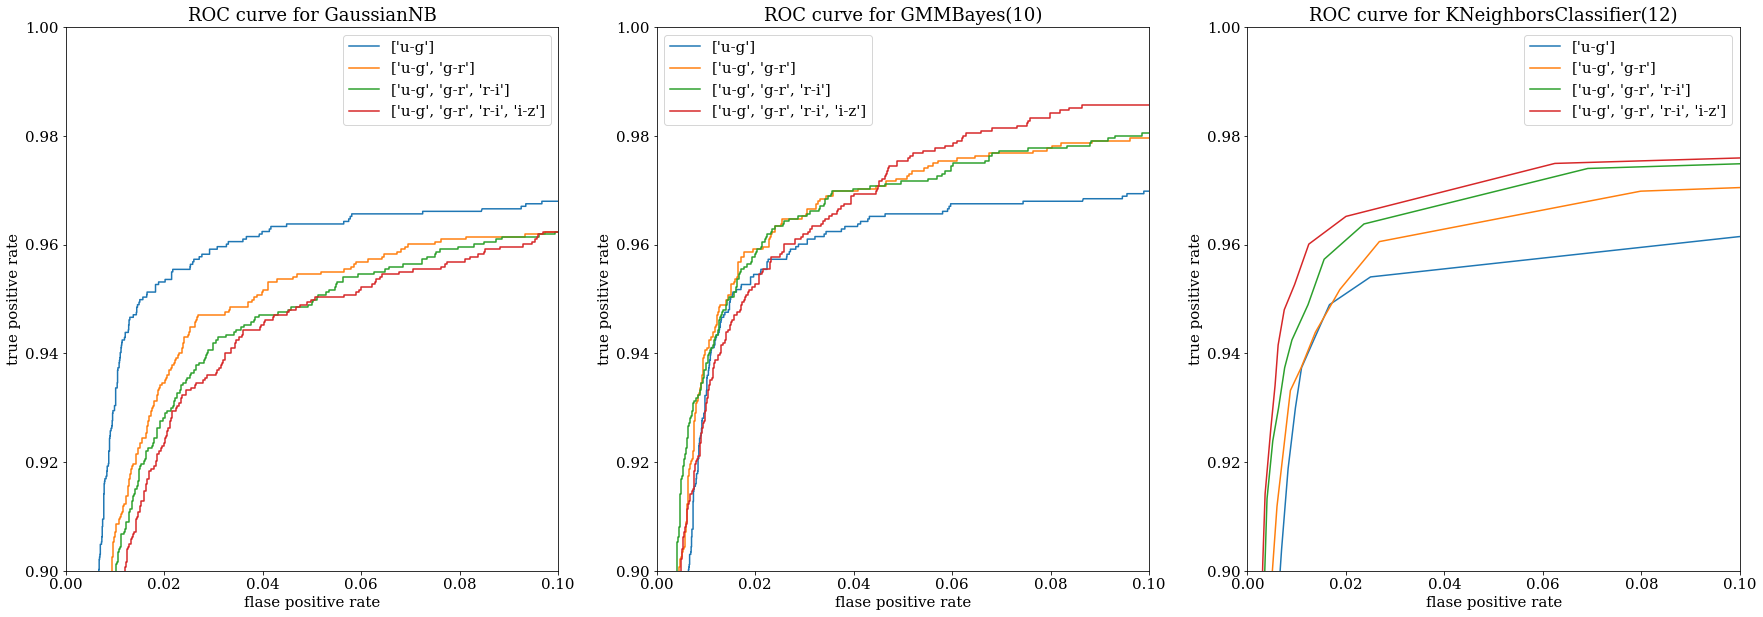

In [24]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(131)
ROC_Features(X, y, GaussianNB())
ax1.set_title('ROC curve for GaussianNB')

ax2 = fig.add_subplot(132)
ROC_Features(X, y, GMMBayes(n_components=ncom_best))
ax2.set_title('ROC curve for GMMBayes('+str(ncom_best)+')')

ax3 = fig.add_subplot(133)
ROC_Features(X, y, KNeighborsClassifier(k_best))
ax3.set_title('ROC curve for KNeighborsClassifier('+str(k_best)+')');

Gaussian Naive Bayes performs worst as we add features!
The GMMB ROC curves for 2,3 and 4 features are quite similar. This suggests that the two first features are the most important.
In case of KNN the classification is similar in case of 4 or 3 features.

We see how completeness and efficiency change with the number of features:

In [34]:
def comp_cont_Features(X, y, clf):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8)
    completeness = np.zeros(4)
    contamination = np.zeros(4)
    
    for i in range(4):
        clf.fit(X_train[:,0:i+1] ,y_train)
        y_prob = clf.predict(X_test[:,0:i+1]) 
        completeness[i], contamination[i] = completeness_contamination(y_prob,y_test)
        #print (completeness[i], contamination[i])
    return completeness, contamination;

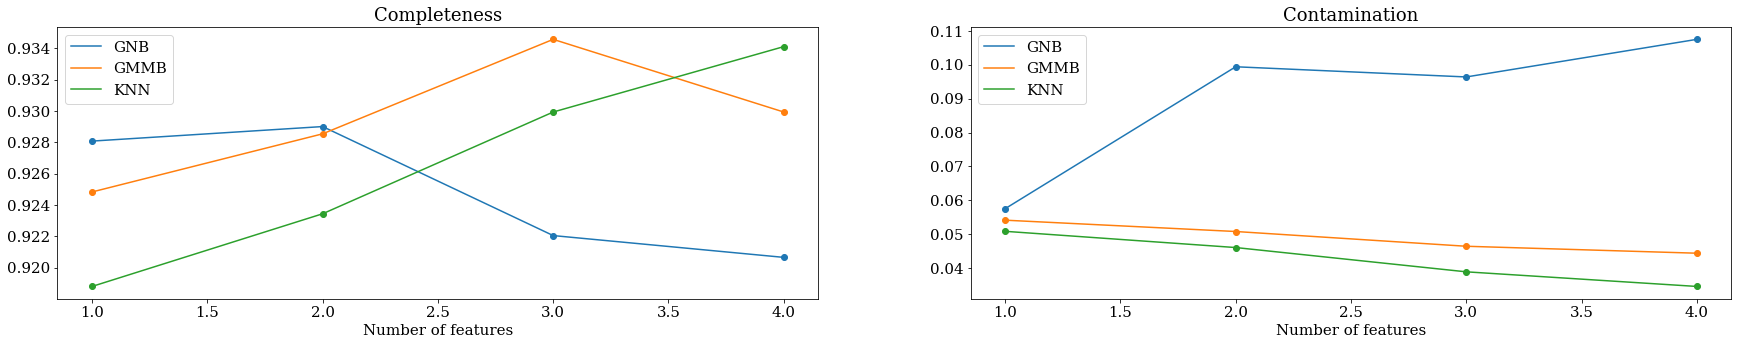

In [39]:
comp1,cont1 = comp_cont_Features(X, y, GaussianNB())
comp2,cont2 = comp_cont_Features(X, y, GMMBayes(n_components=ncom_best, random_state=2))
comp3,cont3 = comp_cont_Features(X, y, KNeighborsClassifier(k_best))

#---------------plot figures---------------------
fig = plt.figure(figsize=(30,5))

# Completeness
ax1 = fig.add_subplot(121)  
ax1.scatter(np.arange(1,5),comp1)
ax1.scatter(np.arange(1,5),comp2)
ax1.scatter(np.arange(1,5),comp3)
ax1.plot(np.arange(1,5),comp1, label='GNB')
ax1.plot(np.arange(1,5),comp2, label='GMMB')
ax1.plot(np.arange(1,5),comp3, label='KNN')
ax1.set_xlabel('Number of features')
ax1.set_title('Completeness')
ax1.legend()

# Contamination
ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(1,5),cont1)
ax2.scatter(np.arange(1,5),cont2)
ax2.scatter(np.arange(1,5),cont3)
ax2.plot(np.arange(1,5),cont1, label='GNB')
ax2.plot(np.arange(1,5),cont2, label='GMMB')
ax2.plot(np.arange(1,5),cont3, label='KNN')
ax2.set_xlabel('Number of features')
ax2.set_title('Contamination')
ax2.legend()

In [40]:
def incr_perc(vec):
    return np.diff(vec)/vec[:3]

print('\n PERCENTAGE INCREASE: \n')
print('        completeness                contamination \n'
      '\n GNB:  ', np.round(incr_perc(comp1),3), '  ',
      np.round(incr_perc(cont1),3),
      '\n GMMB: ', np.round(incr_perc(comp2),3), '    ',
      np.round(incr_perc(cont2),3),
      '\n KNN:  ',  np.round(incr_perc(comp3),3), '     ',
       np.round(incr_perc(cont3),3))


 PERCENTAGE INCREASE: 

        completeness                contamination 

 GNB:   [ 0.001 -0.007 -0.002]    [ 0.729 -0.03   0.115] 
 GMMB:  [ 0.004  0.006 -0.005]      [-0.062 -0.086 -0.044] 
 KNN:   [0.005 0.007 0.004]       [-0.094 -0.156 -0.111]


KNN: both contamination and completeness improve with N features!

GMMB: Completeness is best at N=3 and then slightely decreases.
The contamination instead decreases always.

GNB: with addition of the second feature the percentage of QSO rightly classified slightly increases ($0.1\%$) while the contamination increases of $\sim 73\%$.
This is due to the fact that the assumption of indepent features is wrong.
Let's see what color combination better satisfy the assumption:

In [223]:
# array containing X with all the possible 2-color combinations as features
combo = []
xticks = []
for i in range(len(X.T)-1):
    for j in range(i, len(X.T)-1):
        print('X shape:', np.array([X[:,i], X[:,j+1]]).T.shape, 
              'features:',features[i], features[j+1])
        combo.append(np.array([X[:,i], X[:,j+1]]).T)
        xticks.append(features[i]+', '+features[j+1])
#§print(np.array(combinations).shape)
#§print(combinations[0].shape)

X shape: (50000, 2) features: u-g g-r
X shape: (50000, 2) features: u-g r-i
X shape: (50000, 2) features: u-g i-z
X shape: (50000, 2) features: g-r r-i
X shape: (50000, 2) features: g-r i-z
X shape: (50000, 2) features: r-i i-z


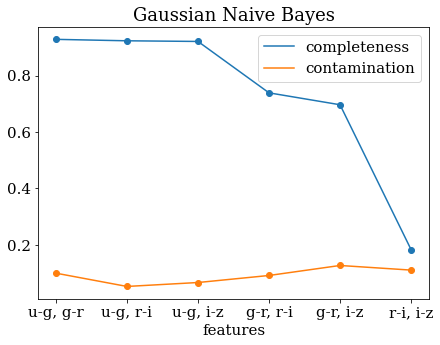

In [287]:
# for all the combinations:
for i in range(len(combinations)):
    
    # split data in test & train
    X_train, X_test, y_train, y_test = train_test_split(
    combo[i], y, test_size=0.3, random_state=8)
    
    # classify
    clf = GaussianNB()
    clf.fit(X_train ,y_train)
    y_prob = clf.predict(X_test) 
    
    # completeness & contamination
    comp[i], cont[i] =  completeness_contamination(y_prob, y_test)

    
#---------------plot figures---------------------

fig = plt.figure(figsize=(7,5))

plt.xticks(np.arange(len(xticks)), xticks)
plt.plot(np.arange(len(xticks)), comp, label='completeness')
plt.scatter(np.arange(len(xticks)), comp)
plt.plot(np.arange(len(xticks)), cont, label='contamination')
plt.scatter(np.arange(len(xticks)), cont)

plt.title('Gaussian Naive Bayes')
plt.xlabel('features')
plt.legend();

In [288]:
print(cont)

[0.0994152  0.05235602 0.06629055 0.0912721  0.12674419 0.11036036]


As regards completeness, the classifier performance is way better while considering u-g color, gets worse when considering g-r and drops when we only consider r-i and i-z. 
Indeed the latter components are the ones that show less the bimodality, while u-g is the component that better shows it.
We see that contamination in the (u-g, g-r) case is even bigger than contamination for (g-r, r-i) case (even if in the latter there is less bimodility)!
Instead it goes down for the other two cases where u-g is present.
This is due to the fact that the assumption of independence is less satisfied for (u-g, g-r).